## Carga de datos

📂 Cargando bases de datos AlvaDesc...


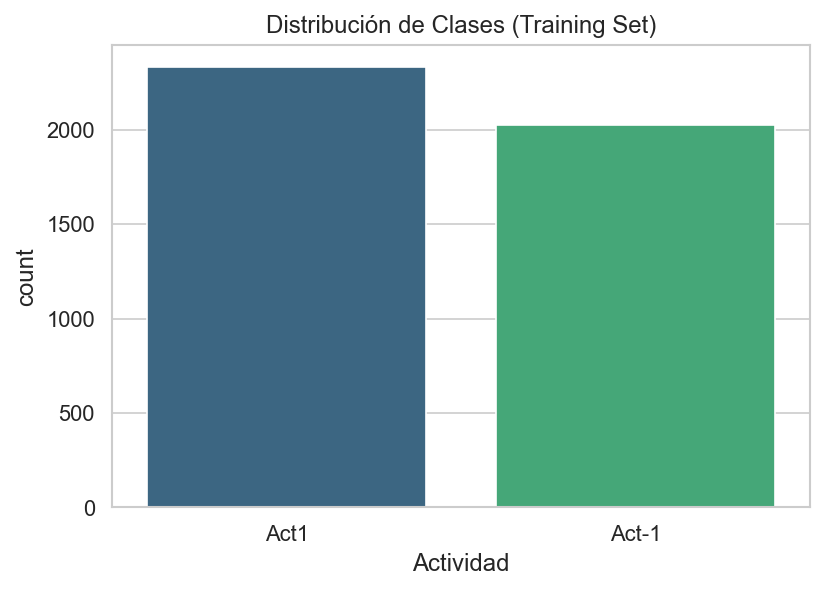

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.ensemble import RandomForestClassifier

sns.set(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.dpi'] = 150 

TARGET_COL = 'Actividad'

def cargar_datos():
    print("Cargando bases de datos")
    train = pd.read_csv(r"C:\Users\benja\Desktop\QSAR/Nueva seleccion de atributos/train.csv")
    test = pd.read_csv(r"C:\Users\benja\Desktop\QSAR/Nueva seleccion de atributos/test.csv")
    ext = pd.read_csv(r"C:\Users\benja\Desktop\QSAR/Nueva seleccion de atributos/external.csv")
    
    # Verificación rápida de balance de clases
    plt.figure(figsize=(6, 4))
    sns.countplot(x=TARGET_COL, data=train, hue=TARGET_COL, legend=False, palette='viridis')
    plt.title("Distribución de Clases (Training Set)")
    plt.show()
    
    return train, test, ext

df_train, df_test, df_ext = cargar_datos()

## Limpieza inicial y analisis de outliers


--- 🔍 Paso 1: Limpieza de Varianza ---
Variables iniciales: 783
Variables tras eliminar constantes: 778


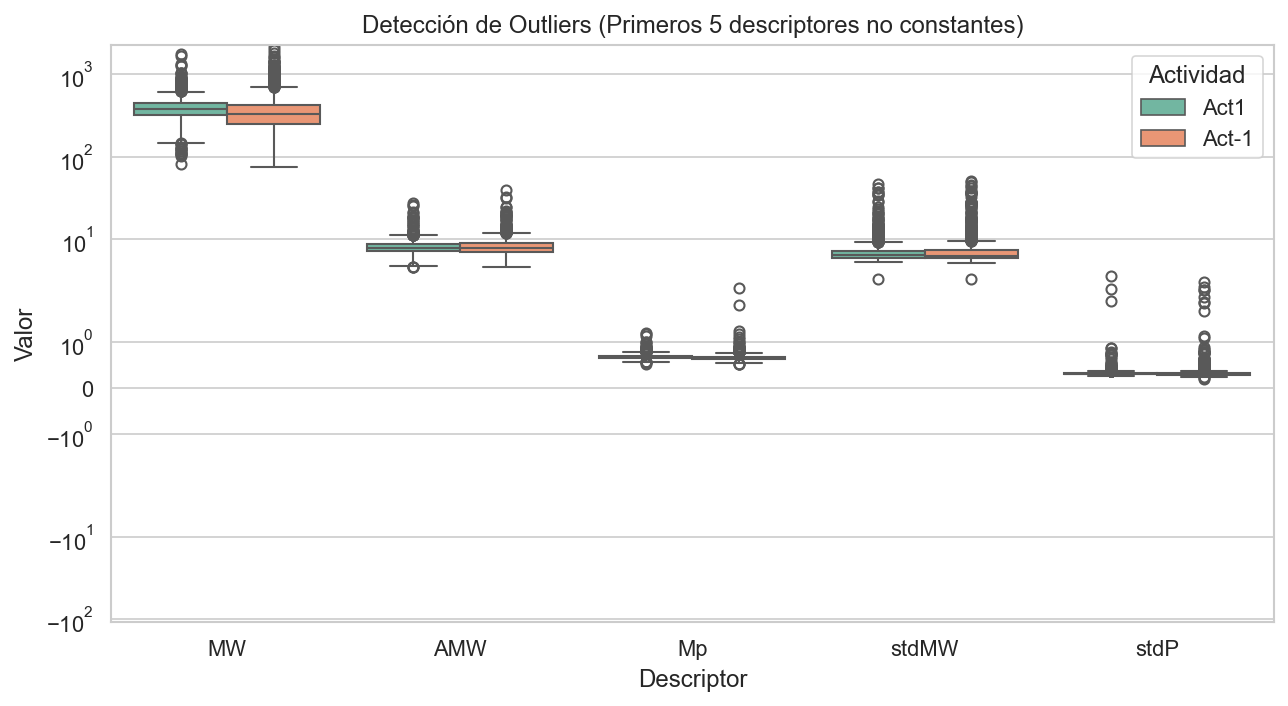

In [11]:
def limpieza_varianza_y_outliers(train, test, ext, target):
    print("\n--- 🔍 Paso 1: Limpieza de Varianza ---")
    
    X_train = train.drop(target, axis=1)
    
    # 1. Filtro de Varianza
    selector = VarianceThreshold(threshold=0.0)
    selector.fit(X_train)
    cols_validas = X_train.columns[selector.get_support()]
    
    print(f"Variables iniciales: {X_train.shape[1]}")
    print(f"Variables tras eliminar constantes: {len(cols_validas)}")
    
    # Actualizar dataframes
    train = train[cols_validas.to_list() + [target]]
    test = test[cols_validas.to_list() + [target]]
    ext = ext[cols_validas.to_list() + [target]]
    
    # 2. Visualización de Outliers (Boxplot de las primeras 5 variables variables)
    # Esto es vital para la sección de EDA de tu tesis
    subset_cols = cols_validas[:5] # Tomamos 5 de muestra para no saturar
    df_melt = train.melt(id_vars=target, value_vars=subset_cols, 
                         var_name='Descriptor', value_name='Valor')
    
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Descriptor', y='Valor', hue=target, data=df_melt, palette="Set2")
    plt.yscale('symlog') # Escala logarítmica para ver mejor rangos dispares
    plt.title("Detección de Outliers (Primeros 5 descriptores no constantes)")
    plt.show()
    
    return train, test, ext

df_train_var, df_test_var, df_ext_var = limpieza_varianza_y_outliers(df_train, df_test, df_ext, TARGET_COL)

Se sometió el conjunto inicial de 783 descriptores moleculares a un análisis de varianza. El objetivo de este filtro fue identificar y eliminar aquellas variables que presentaban valores constantes ($Var = 0$), dado que estos descriptores no aportan capacidad discriminante al modelo.Tras este procedimiento, se eliminaron únicamente 5 variables, resultando en un subconjunto de 778 descriptores operativos. Esta reducción marginal (menos del 1%) indica que la gran mayoría de las propiedades calculadas presentan variabilidad dentro del espacio químico estudiado, lo cual confirma la riqueza informativa del dataset inicial, pero a su vez subraya la necesidad de aplicar métodos de selección más estrictos en etapas posteriores para manejar la alta dimensionalidad.

## Seleccion con P-value(Mann-Whitney)


--- 🧪 Paso 2: Test Estadístico (Mann-Whitney U) Corregido ---
Analizando columna objetivo 'Actividad'...
Grupo 1 (Act1): 2332 muestras
Grupo 2 (Act-1): 2025 muestras
Calculando p-values para 778 variables...
✅ Descriptores estadísticamente significativos (p < 0.05): 652 de 778


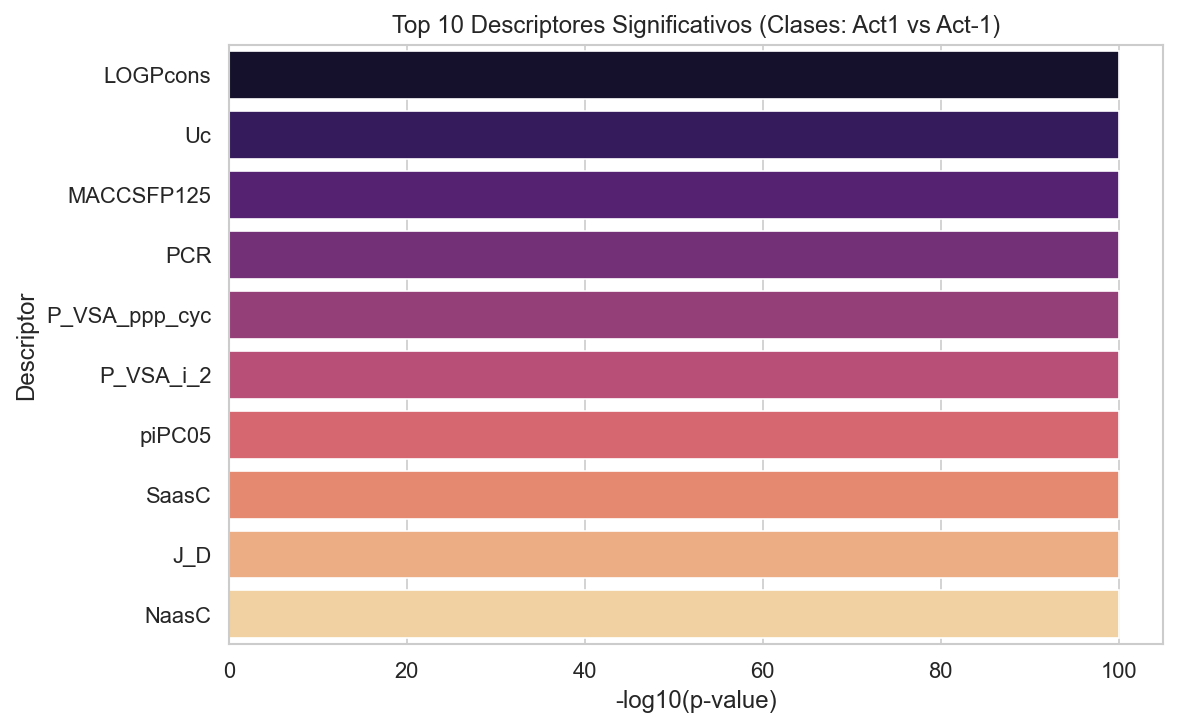

In [ ]:
def filtro_estadistico_pvalue(df, target, alpha=0.05):
    print("Paso 2: Test Estadístico (Mann-Whitney U)")
    
    # 1. DIAGNÓSTICO DE CLASES
    print(f"Analizando columna objetivo '{target}'...")
    clases_unicas = df[target].unique()
    
    # Verificar que sea binario
    if len(clases_unicas) != 2:
        print(f" ALERTA: Se encontraron {len(clases_unicas)} clases: {clases_unicas}")
        print("El test Mann-Whitney requiere exactamente 2 grupos (ej: Activo/Inactivo).")
        # Si hay solo 1 clase, no se puede hacer nada
        if len(clases_unicas) < 2:
            return [], pd.DataFrame()
            
    clase_1 = clases_unicas[0]
    clase_2 = clases_unicas[1]
    
    group_1_data = df[df[target] == clase_1]
    group_2_data = df[df[target] == clase_2]
    
    print(f"Grupo 1 ({clase_1}): {len(group_1_data)} muestras")
    print(f"Grupo 2 ({clase_2}): {len(group_2_data)} muestras")
    
    features = df.drop(target, axis=1).columns
    significant_cols = []
    p_values = []
    
    print(f"Calculando p-values para {len(features)} variables...")
    
    for col in features:
        try:
            # Obtener los valores y limpiar NaNs al vuelo para el test
            vals1 = group_1_data[col].dropna()
            vals2 = group_2_data[col].dropna()
            
            # Verificar que queden datos tras limpiar NaNs
            if len(vals1) < 5 or len(vals2) < 5:
                # Si hay muy pocos datos en una columna específica, la saltamos
                continue
                
            # Mann-Whitney U test
            # nan_policy='omit' es crucial si hay huecos en los datos
            stat, p = stats.mannwhitneyu(vals1, vals2, alternative='two-sided')
            
            if p < alpha:
                significant_cols.append(col)
                p_values.append(p)
                
        except Exception as e:
            # Si falla una columna específica, no detenemos todo el proceso
            # print(f"Error en columna {col}: {e}")
            continue
            
    print(f" Descriptores estadísticamente significativos (p < {alpha}): {len(significant_cols)} de {len(features)}")
    
    if len(significant_cols) == 0:
        print("⚠️ CUIDADO: Ninguna variable pasó el filtro. Revisa si los datos están normalizados o si la columna Target es correcta.")
        # Retornamos todo para no romper el flujo, pero avisando
        return list(features), pd.DataFrame()
    
    # Crear tabla de resultados
    stats_df = pd.DataFrame({'Descriptor': significant_cols, 'p_value': p_values})
    stats_df = stats_df.sort_values('p_value')
    
    # Graficar
    if not stats_df.empty:
        stats_df['log_p'] = -np.log10(stats_df['p_value'] + 1e-100) # Evitar log(0)
        plt.figure(figsize=(8, 5))
        sns.barplot(x='log_p', y='Descriptor', data=stats_df.head(10), hue='Descriptor', legend=False, palette='magma')
        plt.title(f"Top 10 Descriptores Significativos (Clases: {clase_1} vs {clase_2})")
        plt.xlabel("-log10(p-value)")
        plt.tight_layout()
        plt.show()
    
    return significant_cols, stats_df

# --- EJECUCIÓN ---
# Asegúrate de pasar el dataframe que salió del filtro de varianza (df_train_var)
significant_vars, stats_table = filtro_estadistico_pvalue(df_train_var, TARGET_COL)

# Actualizar los dataframes
if len(significant_vars) > 0:
    df_train_p = df_train_var[significant_vars + [TARGET_COL]]
    df_test_p = df_test_var[significant_vars + [TARGET_COL]]
    df_ext_p = df_ext_var[significant_vars + [TARGET_COL]]
else:
    # Si falla, mantenemos los datos anteriores para seguir probando
    df_train_p = df_train_var
    df_test_p = df_test_var
    df_ext_p = df_ext_var

Se evaluó la relevancia estadística de los 778 descriptores restantes mediante la prueba no paramétrica U de Mann-Whitney ($\alpha = 0.05$), comparando las poblaciones de compuestos activos e inactivos.
Los resultados indicaron que 126 variables no presentaban diferencias significativas entre las clases, por lo que fueron descartadas. De este modo, se conservaron 652 descriptores con capacidad discriminante.

## Analisis de correlacion de Spearman


--- 📉 Paso 3: Eliminación de Multicolinealidad (Spearman) ---


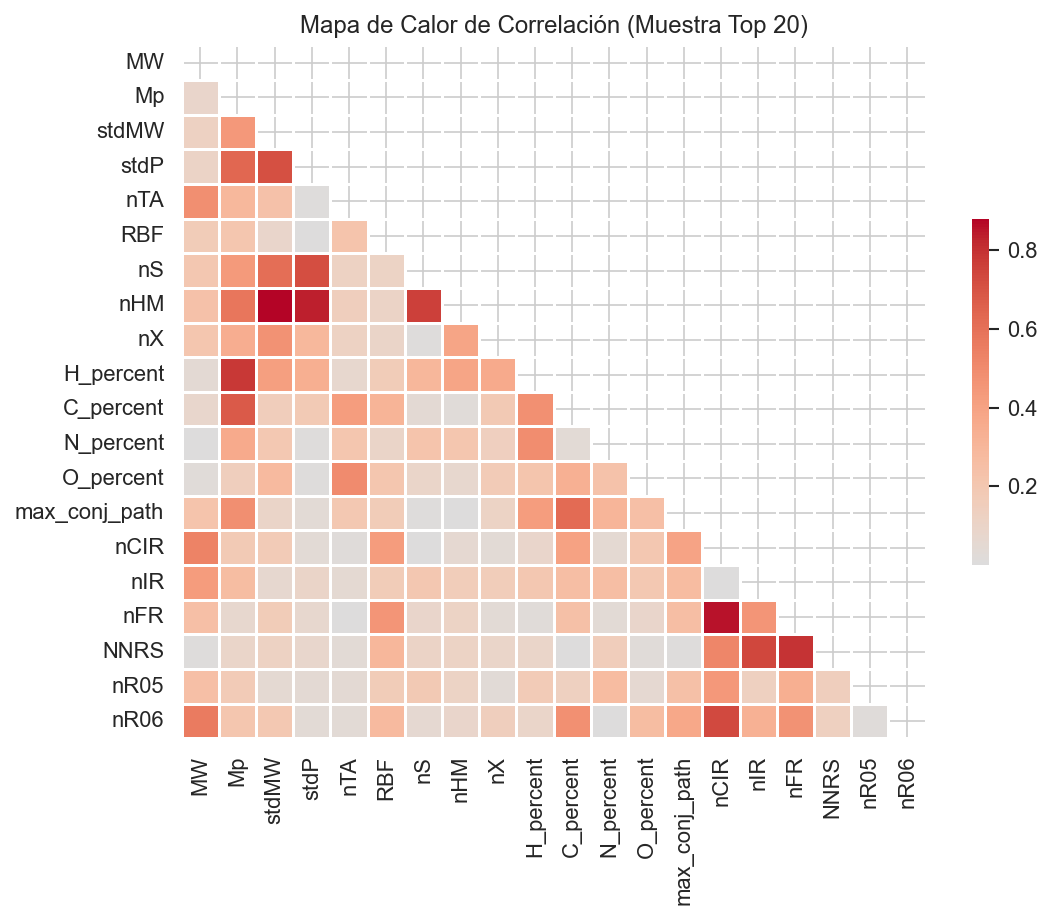

Variables eliminadas por correlación > 0.9: 122


In [ ]:
def filtro_correlacion_grafico(train, test, ext, target, threshold=0.90):
    print("\n--- 📉 Paso 3: Eliminación de Multicolinealidad (Spearman) ---")
    
    X = train.drop(target, axis=1)
    corr_matrix = X.corr(method='spearman').abs()
    
    # GRÁFICO PRE-FILTRO (Solo una muestra si son muchas variables)
    subset_corr = corr_matrix.iloc[:20, :20] 
    plt.figure(figsize=(8, 6))
    mask = np.triu(np.ones_like(subset_corr, dtype=bool))
    sns.heatmap(subset_corr, mask=mask, cmap='coolwarm', center=0, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title("Mapa de Calor de Correlación (Muestra Top 20)")
    plt.show()
    
    # Algoritmo de eliminación
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    print(f"Variables eliminadas por correlación > {threshold}: {len(to_drop)}")
    
    cols_finales = [c for c in X.columns if c not in to_drop]
    
    return train[cols_finales + [target]], test[cols_finales + [target]], ext[cols_finales + [target]]

df_train_corr, df_test_corr, df_ext_corr = filtro_correlacion_grafico(df_train_p, df_test_p, df_ext_p, TARGET_COL)

Para evitar la multicolinealidad y reducir la redundancia intrinseca del conjunto de datos se estableció un umbral de corte estricto de $|r| > 0.9$. Cuando dos variables superaban este coeficiente, se consideraban portadoras de información redundante, procediendo a eliminar aquella con menor correlación individual respecto a la variable objetivo (Actividad).
Se eliminaron 122 variables con alta correlacion, por lo que quedaron 530 descriptores independientes


## RFE 


--- 🤖 Paso 4: Selección Final RFE (Top 50) ---
Entrenando RFE para encontrar las mejores variables...
✅ Selección completada. Variables elegidas: 50


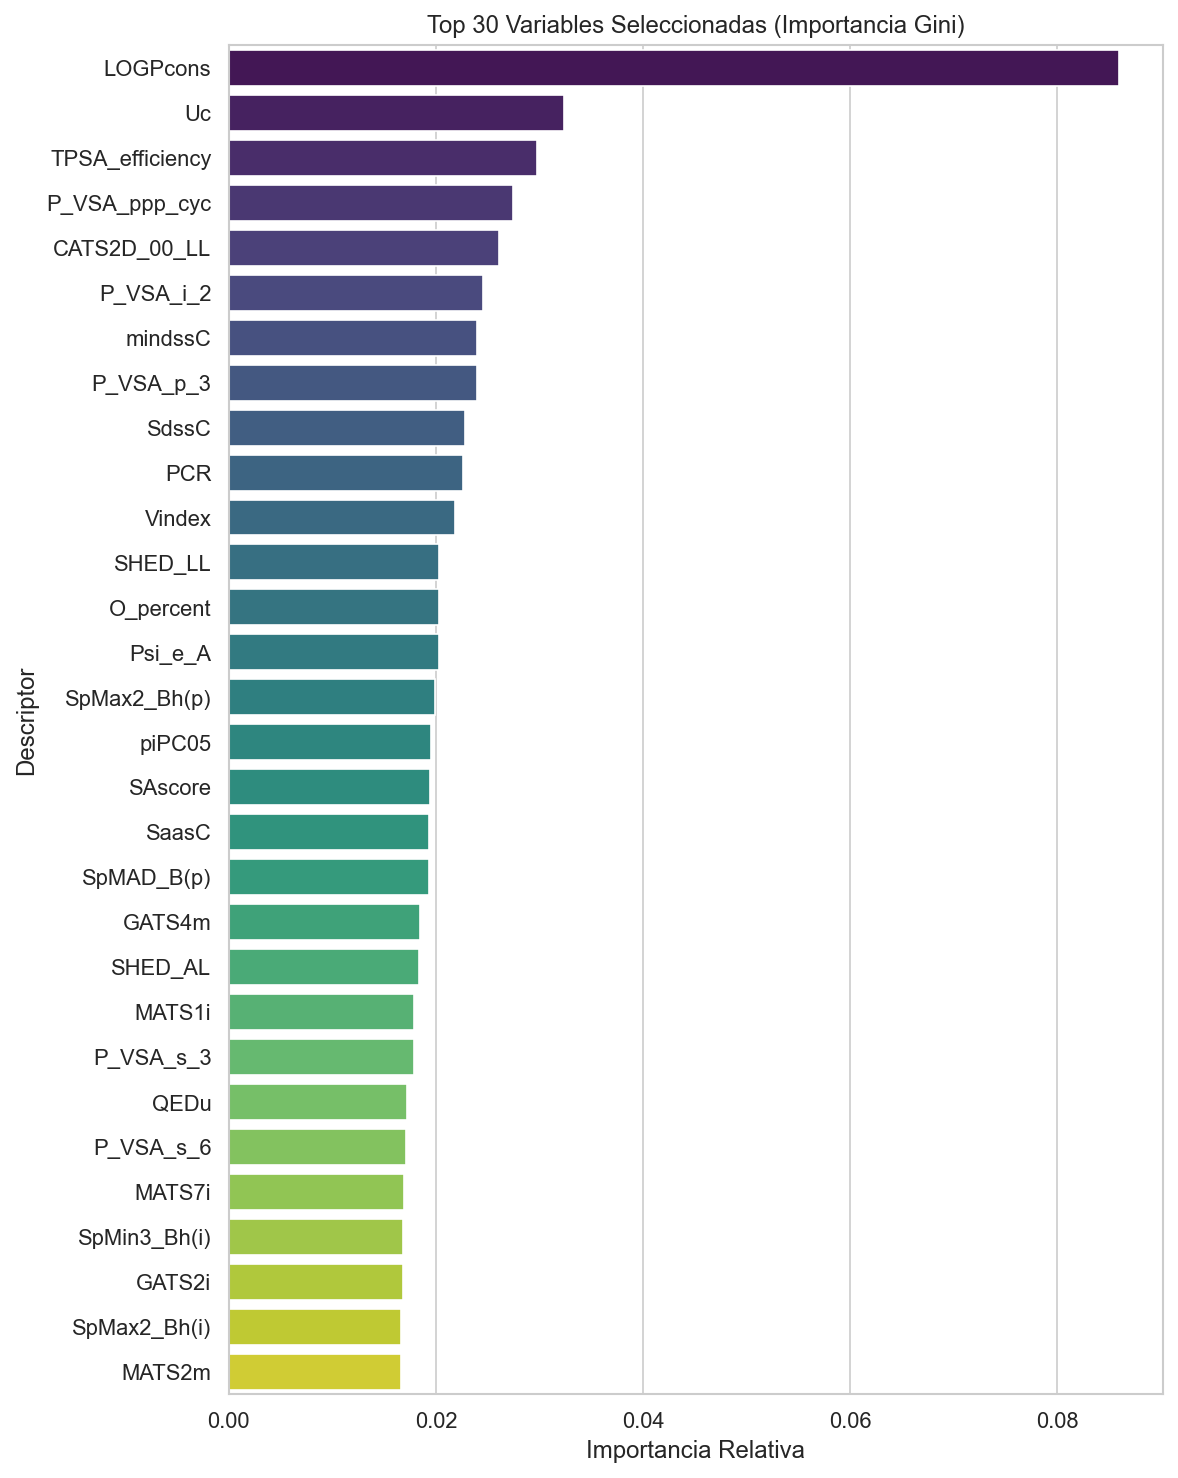


💾 Guardando archivos finales para Weka...
¡Proceso finalizado con éxito!


In [ ]:
def paso_4_rfe_final_con_grafico(train, test, ext, target, n_features=50):
    print(f" Paso 4: Selección Final RFE (Top {n_features})")
    
    X = train.drop(target, axis=1)
    y = train[target]
    
    # 1. Ejecutar RFE
    model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
    print("Entrenando RFE para encontrar las mejores variables...")
    
    rfe = RFE(estimator=model, n_features_to_select=n_features, step=0.05)
    rfe.fit(X, y)
    
    selected_cols = X.columns[rfe.support_]
    print(f"✅ Selección completada. Variables elegidas: {len(selected_cols)}")
    
    # 2. Calcular Importancia Real (Gini) para el Gráfico
    # Re-entrenamos el modelo solo con las elegidas para sacar los valores de importancia
    model.fit(X[selected_cols], y)
    
    importances = pd.DataFrame({
        'Descriptor': selected_cols,
        'Importancia': model.feature_importances_
    }).sort_values('Importancia', ascending=False)
    
    # --- ARREGLO DEL GRÁFICO AQUÍ ---
    plt.figure(figsize=(8, 10))
    # Se añade hue='Descriptor' y legend=False
    sns.barplot(x='Importancia', y='Descriptor', data=importances.head(30), 
                hue='Descriptor', legend=False, palette='viridis')
    
    plt.title(f"Top 30 Variables Seleccionadas (Importancia Gini)")
    plt.xlabel("Importancia Relativa")
    plt.tight_layout() # Ajusta para que no se corten los nombres largos
    plt.show()
    
    # 3. Guardar Archivos Finales
    final_cols = selected_cols.to_list() + [target]
    
    print("Guardando archivos finales para Weka...")
    train[final_cols].to_csv("TESIS_Training_Final.csv", index=False)
    test[final_cols].to_csv("TESIS_Test_Final.csv", index=False)
    ext[final_cols].to_csv("TESIS_External_Final.csv", index=False)
    
    # Guardar tabla de importancia (útil para el anexo de la tesis)
    importances.to_csv("TESIS_Anexo_Importancia.csv", index=False)
    
    print("¡Proceso finalizado con éxito!")

# EJECUTAR
paso_4_rfe_final_con_grafico(df_train_corr, df_test_corr, df_ext_corr, TARGET_COL, n_features=50)

Se aplico la eliminacion recursiva de caracteristicas(RFE) sobre los descriptores restantes, se evalua la interaccion conjunta de los datos y su contribucion real al rendimiento predictivo.
De este proceso se extrajo un subconjunto final de las 50 variables más relevantes. Esta reducción del ~90% respecto al set correlacionado tuvo como objetivo generar un conjunto de datos compacto y de alta calidad para ser utilizado en WEKA para optimizar el costo computacional sin sacrificar poder predictivo